In [21]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter
from konlpy.tag import Komoran
komoran = Komoran()
from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt 
%matplotlib inline
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [4]:
jdf = pd.read_csv('pre_joy_list.csv')
jdf['label'] = 1
jdf.head(1)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
0,32352195,You and I,네이비쿼카(NavyQuokka),You and I,[50],너와 난 Never Ending Story 부를게 이 Melody 이 노랠 들어...,https://image.bugsm.co.kr/album/images/200/204...,"['너와', '난', 'Never', 'Ending', 'Story', '부를게',...",1


In [5]:
sdf = pd.read_csv('pre_sad_list.csv')
sdf['label'] = 0
sdf.head(1)

,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
0,6127308,시간을 거슬러 (낮에 뜨는 달 X 케이윌),케이윌,시간을 거슬러 (낮에 뜨는 달 X 케이윌),"[2,076]",구름에 빛은 흐려지고 창가에 요란히 내리는 빗물 소리만큼 시린 기억들이 내 마...,https://image.bugsm.co.kr/album/images/200/406...,"['구름에', '빛은', '흐려지고', '창가에', '요란히', '내리는', '빗물...",0


In [6]:
jsdf = sdf.append(jdf)
jsdf.reset_index(inplace=True)
jsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       531 non-null    int64 
 1   song_id     531 non-null    int64 
 2   song_name   531 non-null    object
 3   artist      531 non-null    object
 4   album       531 non-null    object
 5   Like_Count  531 non-null    object
 6   Lyric       521 non-null    object
 7   cover_url   531 non-null    object
 8   words       531 non-null    object
 9   label       531 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 41.6+ KB


## 전처리

In [7]:
print(jsdf.isnull().sum())

index          0
song_id        0
song_name      0
artist         0
album          0
Like_Count     0
Lyric         10
cover_url      0
words          0
label          0
dtype: int64


In [8]:
jsdf.loc[jsdf.Lyric.isnull()] # 가사없음

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
217,217,80389448,White,타블로+페니(이터널 모닝),Eternal Morning - Soundtrack To A Lost Film,"[2,309]",NaN,https://image.bugsm.co.kr/album/images/200/803...,[],0
219,219,1817482,[권리없는 곡],Ryuichi Sakamoto(류이치 사카모토/坂本龍一),Playing The Piano,"[7,349]",NaN,https://image.bugsm.co.kr/album/images/200/202...,[],0
221,221,9500553,바다의 선율 II,이루마(Yiruma),인어공주 OST,"[2,118]",NaN,https://image.bugsm.co.kr/album/images/200/950...,[],0
222,222,31922993,Endless Story,개미,부부의 세계 OST Special,[58],NaN,https://image.bugsm.co.kr/album/images/200/203...,[],0
224,224,3877117,"돌이킬 수 없는 걸음 (장화홍련, 메모리즈 OST)",Ttoyo Studio Orchestra,The Good Movie Music,[166],NaN,https://image.bugsm.co.kr/album/images/200/479...,[],0
226,226,493148,Last Carnival,어쿠스틱카페(Acoustic Cafe),For Your Memories,"[16,906]",NaN,https://image.bugsm.co.kr/album/images/200/330...,[],0
230,230,31432309,석양,남혜승,남자친구 (tvN 수목드라마) OST,[17],NaN,https://image.bugsm.co.kr/album/images/200/202...,[],0
231,231,80076017,Merry-Go-Round,Hisaishi Joe(히사이시 조/久石 讓),FREEDOM PIANO STORIES 4,"[8,275]",NaN,https://image.bugsm.co.kr/album/images/200/800...,[],0
232,232,5584965,아이에게,김형석,눈이 부시게 (JTBC 월화드라마) OST - With Piano,[21],NaN,https://image.bugsm.co.kr/album/images/200/860...,[],0
336,88,87306,다 줄꺼야 (SEQ ver.),조규만,다 줄꺼야,"[2,071]",NaN,https://image.bugsm.co.kr/album/images/200/47/...,[],1


In [9]:
jsdf = jsdf.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(jsdf.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [10]:
print(len(jsdf)) # 데이터 개수

521


In [11]:
jsdf['Lyric'] = jsdf['Lyric'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
jsdf[:5]

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
0,0,6127308,시간을 거슬러 (낮에 뜨는 달 X 케이윌),케이윌,시간을 거슬러 (낮에 뜨는 달 X 케이윌),"[2,076]",구름에 빛은 흐려지고 창가에 요란히 내리는 빗물 소리만큼 시린 기억들이 내 마...,https://image.bugsm.co.kr/album/images/200/406...,"['구름에', '빛은', '흐려지고', '창가에', '요란히', '내리는', '빗물...",0
1,1,32333010,왜? 날,백예린 (Yerin Baek),선물,"[1,408]",그대 내게 기대어 편안하게 쉬고 있을 때면 느끼죠 그대 나를 원한다는 걸 이제...,https://image.bugsm.co.kr/album/images/200/204...,"['그대', '내게', '기대어', '편안하게', '쉬고', '있을', '때면', ...",0
2,2,31657872,조금 더 외로워지겠지,김나영,검색어를 입력하세요 WWW OST,[133],조금만 덜 좋아했다면 우린 어쩜 모른 척 살았을까 지쳐가는 너를 흔들리는 나를...,https://image.bugsm.co.kr/album/images/200/202...,"['조금만', '덜', '좋아했다면', '우린', '어쩜', '모른', '척', '...",0
3,3,6131291,신촌을 못가,허각,신촌을 못가,[219],신촌을 못가 한번을 못가 혹시 너와 마주칠까 봐 널 보면 눈물이 터질까 봐 친...,https://image.bugsm.co.kr/album/images/200/406...,"['신촌을', '못가', '한번을', '못가', '혹시', '너와', '마주칠까',...",0
4,4,6115656,지나가요 (Duet 최유리),스무살,지나가요 (Duet 최유리),[254],사랑이 지나가요 결국엔 우리 둘도 이렇게 흘러가네요 잘 지내란 말 이따위...,https://image.bugsm.co.kr/album/images/200/405...,"['사랑이', '지나가요', '결국엔', '우리', '둘도', '이렇게', '흘러가...",0


In [12]:
jsdf['Lyric'] = jsdf['Lyric'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
jsdf['Lyric'].replace('', np.nan, inplace=True)
print(jsdf.isnull().sum())

index         0
song_id       0
song_name     0
artist        0
album         0
Like_Count    0
Lyric         5
cover_url     0
words         0
label         0
dtype: int64


In [13]:
jsdf[jsdf['Lyric'].isnull()] # 가사가 영어로만 이루어져 있어서 NaN값인 노래들

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
225,225,1814881,24-25,Kings Of Convenience(킹스 오브 컨비니언스),Declaration Of Dependence,"[2,637]",NaN,https://image.bugsm.co.kr/album/images/200/201...,"[""She'll"", 'be', 'gone', 'soon', 'You', 'can',...",0
228,228,80041751,Something About Us,Daft Punk(다프트 펑크),Discovery,"[6,928]",NaN,https://image.bugsm.co.kr/album/images/200/800...,"['It', 'might', 'not', 'be', 'the', 'right', '...",0
425,177,32321750,So In Love (Feat. Filipe Santos),vvav (웨이브),So In Love,[18],NaN,https://image.bugsm.co.kr/album/images/200/204...,"['I', ""don't"", 'know', 'where', 'to', 'start',...",1
434,186,5896896,fallin (feat.Liss),죠지,fallin (feat.Liss),[559],NaN,https://image.bugsm.co.kr/album/images/200/978...,"[""Don't"", 'know', 'what', ""I've"", 'been', 'thi...",1
469,221,32338490,xo,G. Nine,xo,[23],NaN,https://image.bugsm.co.kr/album/images/200/204...,"['Er', 'ya', 'this', ""song's"", 'for', 'ya', 'H...",1


In [14]:
jsdf = jsdf.dropna(how = 'any')

In [15]:
print(len(jsdf))

516


In [16]:
print('전처리 후 데이터의 개수 :',len(jsdf))

전처리 후 데이터의 개수 : 516


In [17]:
# 불용어 (가사 빈도수 높은 + 감정분류와 무관한 단어 추가 중)
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하',
          'know','no','of','let','my','사랑','수','너','내','나','그','난','봐','돼','건','모든',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기','우리','그대','다시',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면','같아','있어','지금',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜','거야']

In [18]:
# 불용어 단어 중복제거
stop_w = set(stop_w)

## 데이터 분리

In [22]:
train_data, test_data = train_test_split(
  jsdf,
  test_size = 0.25,
  random_state = 5
)

In [23]:
# 학습 데이터
X_train = []
for sentence in tqdm(train_data['Lyric']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 387/387 [00:11<00:00, 32.37it/s]


In [24]:
# 테스트 데이터 
X_test = []
for sentence in tqdm(test_data['Lyric']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 129/129 [00:01<00:00, 68.78it/s]


In [66]:
X_train[:1]

array([list(['이르다', '이상하다', '없다', '하루', '기다', '사람', '많이', '언제나', '내겐', '귀찮다', '이다', '을', '받다', '만', '익숙하다', '내다', '뭘', '달라지다', '조차', '궁금하다', '빠지다', '밖에', '모르다', '되다', '보다', '대다', '생각', '사람', '에게만', '그렇다', '보다', '아끼다', '두다', '맘', '을', '받다', '어제', '예요', '관심', '없다', '남자', '옷', '을', '고르다', '발견', '꼭', '배우다', '않다', '바꾸다', '그대만', '생각', '을', '받다', '익숙하다', '모두', '주다', '싶다', '에게만', '나오다', '같다', '빠지다', '밖에', '모르다', '되다', '보다', '대다', '생각', '사람', '에게만', '그렇다', '보다', '아끼다', '두다', '맘', '을', '받다', '이별', '이란', '없다', '에겐', '첫사랑', '인데', '혹시', '깨지다', '이제', '다시다', '을', '되다', '모르다', '그렇다', '되다', '보다', '대다', '생각', '그렇다', '에게만', '에게만', '이르다', '그렇다', '오', '아끼다', '두다', '맘', '을', '받다'])],
      dtype=object)

## 정답 데이터 저장

In [25]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [50]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(drop_train)

[]


In [57]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_test))
print(len(y_test))

387
387
129
129
129
129


## 정수 인코딩
* 모델이 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행
* 단어 집합이 생성되는 동시에 각 단어에 고유한 정수를 부여함
* 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, <br>높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미함

## 빈도수 확인 (3회 미만)

In [67]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

In [68]:
# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3302
등장 빈도가 2번 이하인 희귀 단어의 수: 1521
단어 집합에서 희귀 단어의 비율: 46.06299212598425
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.545037607778389


In [69]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1782


단어 집합을 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환

In [70]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 정수 인코딩 확인

In [73]:
print(X_train[:1])

[[388, 673, 2, 50, 184, 10, 95, 157, 171, 990, 59, 1, 116, 6, 515, 16, 477, 389, 345, 390, 354, 204, 14, 15, 3, 26, 24, 10, 355, 9, 3, 309, 117, 17, 1, 116, 375, 264, 1261, 2, 158, 570, 1, 724, 106, 893, 4, 820, 601, 24, 1, 116, 515, 96, 47, 7, 355, 185, 5, 354, 204, 14, 15, 3, 26, 24, 10, 355, 9, 3, 309, 117, 17, 1, 116, 78, 225, 2, 444, 894, 194, 241, 1262, 53, 288, 1, 15, 14, 9, 15, 3, 26, 24, 9, 355, 355, 388, 9, 107, 309, 117, 17, 1, 116]]


## 패딩

가사의 최대 길이 : 238
가사의 평균 길이 : 107.56072351421189


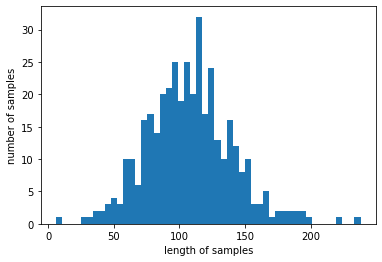

In [74]:
print('가사의 최대 길이 :',max(len(l) for l in X_train))
print('가사의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [45]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [75]:
max_len = 170
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 170 이하인 샘플의 비율: 96.64082687338501


## 모든 샘플의 길이를 max_len로 조정

In [76]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

---

## 모델 적용

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, LSTM, Embedding, Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [109]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 가사입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 가사입니다.\n".format((1 - score) * 100))

---

## Bidirectional(LSTM(N))
양방향 many-to-one LSTM
*  return_sequence=False (default) : 양방향 & many-to-one 유형
* 양방향(Bidirection) 재귀 모델은 시간적으로 앞의 데이터만 가지고는 올바른 예측을 할 수 없다는 문제점을 해결하기 위하여,<br> 정방향뿐 아닌 역방향의 전파까지도 실행시키는 것을 의미함
* LSTM에 return_sequence=True, Bidirectional이면서 TimeDistributed() 함수가 사용되면 양방향 many-to-many 유형

> https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

## T1

In [85]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100,
        # Use masking to handle the variable sequence lengths
                              mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

## T2
* model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])<br>
*  loss: 0.0038 - acc: 0.9968 - val_loss: 1.4538 - val_acc: 0.8590<br>
* 100s

In [148]:
model = Sequential()
model.add(Embedding(vocab_size, 100, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
# model.add(Dense(32,activation="relu"))
# model.add(Dense(16,activation="relu"))
model.add(Dense(1)) # , activation='sigmoid'

In [149]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
5/5 [==============================] - 16s 2s/step - loss: 1.8555 - acc: 0.4725 - val_loss: 1.1392 - val_acc: 0.5128

Epoch 00001: val_acc did not improve from 0.85897
Epoch 2/15
5/5 [==============================] - 5s 1s/step - loss: 1.1143 - acc: 0.4725 - val_loss: 1.0063 - val_acc: 0.5128

Epoch 00002: val_acc did not improve from 0.85897
Epoch 3/15
5/5 [==============================] - 7s 1s/step - loss: 0.9455 - acc: 0.4725 - val_loss: 0.8891 - val_acc: 0.5128

Epoch 00003: val_acc did not improve from 0.85897
Epoch 4/15
5/5 [==============================] - 7s 1s/step - loss: 0.7929 - acc: 0.4725 - val_loss: 0.7806 - val_acc: 0.5128

Epoch 00004: val_acc did not improve from 0.85897
Epoch 5/15
5/5 [==============================] - 6s 1s/step - loss: 0.6469 - acc: 0.4822 - val_loss: 0.6873 - val_acc: 0.5128

Epoch 00005: val_acc did not improve from 0.85897
Epoch 6/15
5/5 [==============================] - 6s 1s/step - loss: 0.4941 - acc: 0.7994 - val_loss: 0.6310 

In [150]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

84.74% 확률로 부정 가사입니다.



##### ?

In [151]:
sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

102.98% 확률로 부정 가사입니다.



In [152]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

73.88% 확률로 부정 가사입니다.



In [153]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

69.82% 확률로 긍정 가사입니다.



In [154]:
sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와 ')

57.16% 확률로 부정 가사입니다.



In [155]:
sentiment_predict('흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야')

99.43% 확률로 부정 가사입니다.



## T3

* model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])<br>
* loss: 0.0881 - acc: 0.9773 - val_loss: 0.5600 - val_acc: 0.8205<br>
* 70s

In [128]:
model = Sequential()
model.add(Embedding(vocab_size, 200, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation='sigmoid')) # , activation='sigmoid'

In [107]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [129]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
5/5 [==============================] - 33s 3s/step - loss: 0.6901 - acc: 0.5599 - val_loss: 0.6869 - val_acc: 0.5000

Epoch 00001: val_acc did not improve from 0.83333
Epoch 2/15
5/5 [==============================] - 4s 812ms/step - loss: 0.7126 - acc: 0.6375 - val_loss: 0.6447 - val_acc: 0.7436

Epoch 00002: val_acc did not improve from 0.83333
Epoch 3/15
5/5 [==============================] - 4s 832ms/step - loss: 0.5817 - acc: 0.9029 - val_loss: 1.4291 - val_acc: 0.6026

Epoch 00003: val_acc did not improve from 0.83333
Epoch 4/15
5/5 [==============================] - 4s 781ms/step - loss: 0.6469 - acc: 0.7670 - val_loss: 0.5306 - val_acc: 0.7308

Epoch 00004: val_acc did not improve from 0.83333
Epoch 5/15
5/5 [==============================] - 4s 842ms/step - loss: 0.3035 - acc: 0.8770 - val_loss: 0.5720 - val_acc: 0.7179

Epoch 00005: val_acc did not improve from 0.83333
Epoch 6/15
5/5 [==============================] - 4s 886ms/step - loss: 0.2373 - acc: 0.9126 - va

In [130]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

57.30% 확률로 부정 가사입니다.



In [131]:
sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

69.10% 확률로 부정 가사입니다.



In [132]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

65.01% 확률로 긍정 가사입니다.



In [133]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

83.30% 확률로 긍정 가사입니다.



In [135]:
sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와 ')

62.56% 확률로 긍정 가사입니다.



In [134]:
sentiment_predict('흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야')

54.33% 확률로 부정 가사입니다.



## T4
* model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])<br>
* loss: 0.0169 - acc: 0.9968 - val_loss: 1.2655 - val_acc: 0.7692<br>
* 90s

In [137]:
model = Sequential()
model.add(Embedding(vocab_size, 200, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation='sigmoid')) # , activation='sigmoid'

In [138]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
5/5 [==============================] - 20s 3s/step - loss: 0.6931 - acc: 0.4790 - val_loss: 0.6931 - val_acc: 0.4615

Epoch 00001: val_acc did not improve from 0.85897
Epoch 2/15
5/5 [==============================] - 6s 1s/step - loss: 0.6840 - acc: 0.8155 - val_loss: 0.6857 - val_acc: 0.6410

Epoch 00002: val_acc did not improve from 0.85897
Epoch 3/15
5/5 [==============================] - 6s 1s/step - loss: 0.6541 - acc: 0.8738 - val_loss: 0.6573 - val_acc: 0.6923

Epoch 00003: val_acc did not improve from 0.85897
Epoch 4/15
5/5 [==============================] - 6s 1s/step - loss: 0.5430 - acc: 0.8414 - val_loss: 0.5456 - val_acc: 0.7436

Epoch 00004: val_acc did not improve from 0.85897
Epoch 5/15
5/5 [==============================] - 7s 1s/step - loss: 0.3951 - acc: 0.9320 - val_loss: 0.5791 - val_acc: 0.7051

Epoch 00005: val_acc did not improve from 0.85897
Epoch 6/15
5/5 [==============================] - 6s 1s/step - loss: 0.3427 - acc: 0.8738 - val_loss: 0.3897 

In [139]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

71.06% 확률로 부정 가사입니다.



In [140]:
sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

98.30% 확률로 부정 가사입니다.



In [141]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

62.60% 확률로 긍정 가사입니다.



In [142]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

85.04% 확률로 긍정 가사입니다.



In [143]:
sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와')

68.58% 확률로 긍정 가사입니다.



In [146]:
sentiment_predict('흔들리는 꽃들 속에서 네 샴푸향이 느껴진거야')

63.77% 확률로 부정 가사입니다.



## T5
* model.add(Embedding(vocab_size, 300, mask_zero=True))
* model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
* loss: 0.0146 - acc: 0.9968 - val_loss: 0.4949 - val_acc: 0.8462
* 113s

In [156]:
model = Sequential()
model.add(Embedding(vocab_size, 300, mask_zero=True))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation='sigmoid')) # , activation='sigmoid'

In [158]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
5/5 [==============================] - 21s 3s/step - loss: 0.6922 - acc: 0.4951 - val_loss: 0.6926 - val_acc: 0.4872

Epoch 00001: val_acc did not improve from 0.85897
Epoch 2/15
5/5 [==============================] - 11s 2s/step - loss: 0.6785 - acc: 0.6149 - val_loss: 0.6856 - val_acc: 0.4872

Epoch 00002: val_acc did not improve from 0.85897
Epoch 3/15
5/5 [==============================] - 12s 2s/step - loss: 0.6304 - acc: 0.8220 - val_loss: 0.6433 - val_acc: 0.6282

Epoch 00003: val_acc did not improve from 0.85897
Epoch 4/15
5/5 [==============================] - 11s 2s/step - loss: 0.4568 - acc: 0.8900 - val_loss: 0.4397 - val_acc: 0.8590

Epoch 00004: val_acc did not improve from 0.85897
Epoch 5/15
5/5 [==============================] - 11s 2s/step - loss: 0.4282 - acc: 0.8706 - val_loss: 0.3564 - val_acc: 0.8333

Epoch 00005: val_acc did not improve from 0.85897
Epoch 6/15
5/5 [==============================] - 11s 2s/step - loss: 0.1714 - acc: 0.9450 - val_loss: 0.

In [159]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

80.98% 확률로 부정 가사입니다.



In [160]:
sentiment_predict('눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며')

98.82% 확률로 부정 가사입니다.



In [161]:
sentiment_predict('나는 나는 행복에 묻힐 거에요')

66.13% 확률로 긍정 가사입니다.



In [162]:
sentiment_predict('눈을 뜨기 힘든 가을 보다 높은 저 하늘이 기분 좋아')

89.89% 확률로 긍정 가사입니다.



In [163]:
sentiment_predict('두 눈에 비친 너의 미소 지친 날 감싸듯 내 맘 비춰 소리없이 찾아와')

68.09% 확률로 긍정 가사입니다.



In [170]:
sentiment_predict('넌 그대로가 사랑이니까 이대로가 좋다 했지')

73.98% 확률로 긍정 가사입니다.



In [171]:
sentiment_predict('손을잡아 너와 함께 난 언제라도 따듯한 폭닥한 이불 널 보면 생각나')

82.29% 확률로 긍정 가사입니다.



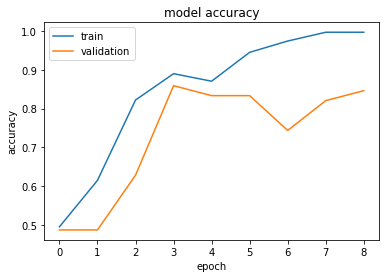

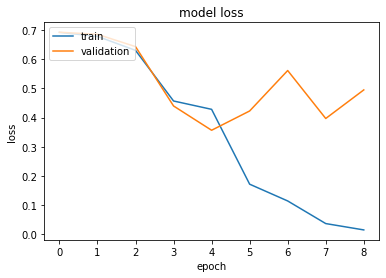

In [173]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 모델 저장

In [184]:
# creates a HDF5 file 'my_model.h5'
model.save('models/biLSTM_w2v.h5')

In [185]:
from keras.models import load_model
predictor = load_model('models/biLSTM_w2v.h5')

---